In [1]:
import psycopg2
import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

randomState = 42

RDKit WARNING: [04:26:15] Enabling RDKit 2019.09.3 jupyter extensions


## Data extraction and data preparation helper functions

In [ ]:
def connect2DB(user = 'chembl', password='chembl', host='127.0.0.1', port='5432', database='chembl_25'):
    connection = psycopg2.connect(user = user,
                    password = password,
                    host = host,
                    port = port,
                    database = database)
    return connection

def getSmilesWithActivity(connection, nRows = None):
    cursor = connection.cursor()
    columns = ['molregno', 'canonical_smiles', 'activity_id', 
           'standard_value', 'standard_units', 'standard_flag', 'standard_type', 'activity_comment',
           'alogp', 'hba', 'hbd', 'psa', 'rtb', 'ro3_pass', 'num_ros_violations', 'molecular_species', 'full_mwt', 'aromatic_rings', 'heavy_atoms', 'qed_weighted']

    cursor.execute("select CS.molregno, \
               CS.canonical_smiles, \
               AC.activity_id, \
               AC.standard_value, \
               AC.standard_units, \
               AC.standard_flag, \
               AC.standard_type, \
               AC.activity_comment, \
               CP.ALOGP, \
               CP.HBA, \
               CP.HBD, \
               CP.PSA, \
               CP.RTB, \
               CP.RO3_PASS, \
               CP.NUM_RO5_VIOLATIONS, \
               CP.MOLECULAR_SPECIES, \
               CP.FULL_MWT, \
               CP.AROMATIC_RINGS, \
               CP.HEAVY_ATOMS, \
               CP.QED_WEIGHTED \
               from COMPOUND_STRUCTURES CS \
               inner join ACTIVITIES AC on CS.molregno = AC.molregno \
               inner join COMPOUND_PROPERTIES CP on CS.molregno = CP.MOLREGNO \
               and (AC.standard_type = 'IC50' or AC.standard_type = 'GI50' or AC.standard_type = 'Potency') \
               and (AC.standard_value IS NOT NULL)")
    if nRows is None:
        molData = pd.DataFrame(cursor.fetchall(), columns = columns)
    elif nRows > 0:
        molData = pd.DataFrame(cursor.fetchmany(nRows), columns = columns)
    return molData

def provideMoleculeStatistics(smiles):
    #print(smiles)
    mol = Chem.MolFromSmiles(smiles)
    
    newSmiles = Chem.MolToSmiles(mol, canonical = True, isomericSmiles = False)
    negativeCharged = sum([ item.GetFormalCharge() if item.GetFormalCharge() < 0 else 0 for item in mol.GetAtoms() ])
    positiveCharged = sum([ item.GetFormalCharge() if item.GetFormalCharge() > 0 else 0 for item in mol.GetAtoms() ])
    
    elementsList = list(set([atom.GetSymbol() for atom in mol.GetAtoms()]))
    numberOfRings = mol.GetRingInfo().NumRings()
    
    numberOfAtoms = len(mol.GetAtoms())
    
    return(newSmiles, negativeCharged, positiveCharged, elementsList, numberOfRings, numberOfAtoms)

import codecs
encodeToUTF8 = False
def canonicalizeSmilesAndProvideDescriptor(smiles):
    try:
        newSmiles, negativeCharged, positiveCharged, elementsList, numberOfRings, numberOfAtoms = provideMoleculeStatistics(smiles)     
    except:
        newSmiles, negativeCharged, positiveCharged, elementsList, numberOfRings, numberOfAtoms = (None, None, None, None, None, None)
        print('Exception!!! :', smiles)
        
    if (encodeToUTF8):
        return((codecs.encode(newSmiles, 'utf-8'), negativeCharged, positiveCharged, elementsList, numberOfRings, numberOfAtoms))
    else:
        return((newSmiles, negativeCharged, positiveCharged, elementsList, numberOfRings, numberOfAtoms))

In [ ]:
connection = connect2DB()
molData = getSmilesWithActivity(connection)

### Imposing some basic restrictions 

In [ ]:
molData = molData[molData['standard_units']=='nM'].reset_index()

In [ ]:
molData = molData[molData['aromatic_rings']<=5]

### Before aggregation

In [ ]:
molData['aromatic_rings'].hist(bins=5)

In [ ]:
aggFunctions = {
            'molregno': ['min', 'count'], 'canonical_smiles': 'min',
            'standard_value': ['min', 'max'],
            'standard_type': 'min',
            'alogp': ['min', 'max'],
            'hba': ['min', 'max'],
            'hbd': ['min', 'max'],
            'psa': ['min', 'max'],
            'rtb': ['min', 'max'],
            'ro3_pass': 'min',
            'num_ros_violations': 'min',
            'molecular_species': 'min',
            'full_mwt': ['min', 'max'],
            'aromatic_rings': 'min',
            'heavy_atoms': 'min',
            'qed_weighted': ['min', 'max']
            }

In [ ]:
grouped = molData.groupby('molregno')
molData = grouped.agg(aggFunctions).reset_index()

## After aggregation

In [ ]:
molData['aromatic_rings'].hist(bins=5)

In [ ]:
with open('molDataAfterAgg.pickle', 'wb') as f:
    pickle.dump(molData, f)

In [ ]:
with open('molDataAfterAgg.pickle', 'rb') as f:
    molData = pickle.load(f)

In [ ]:
sourceColumn = ('canonical_smiles', 'min')
nTotal = len(molData)
nStart = 0
nSize = 100000
nBatch = np.ceil((nTotal - nStart)/nSize).astype(int)
for iii in range(nBatch):
    iBeg = nStart + iii * nSize
    if (iii == nBatch - 1):
        iEnd = nTotal
    else:
        iEnd = nStart + (iii + 1) * nSize
    print('Batch ID: '+str(iii))
    result = molData.loc[iBeg:iEnd, sourceColumn].apply(canonicalizeSmilesAndProvideDescriptor)
    molData.loc[iBeg:iEnd, 'canonicalSmiles'] = [item[0] for item in result]
    molData.loc[iBeg:iEnd, 'negativeCharged'] = [item[1] for item in result]
    molData.loc[iBeg:iEnd, 'positiveCharged'] = [item[2] for item in result]
    molData.loc[iBeg:iEnd, 'elementsSet'] = [item[3] for item in result]
    molData.loc[iBeg:iEnd, 'numberOfRings'] = [item[4] for item in result]
    molData.loc[iBeg:iEnd, 'numberOfAtoms'] = [item[5] for item in result]

In [ ]:
molData.head()

In [ ]:
molData = molData.drop(columns = [('canonical_smiles', 'min')])

In [ ]:
molData['activityMin'] = molData[('standard_value', 'min')]
molData['activityMax'] = molData[('standard_value', 'max')]
molData = molData.drop(columns = [('standard_value', 'min'), ('standard_value', 'max')])

In [ ]:
molData['activityType'] = molData[('standard_type', 'min')]
molData = molData.drop(columns = [('standard_type', 'min')])

In [ ]:
molData['alogP'] = molData[('alogp', 'min')]
molData = molData.drop(columns = [('alogp', 'min'), ('alogp', 'max')])

In [ ]:
molData['molregIdx'] = molData[('molregno', 'min')]
molData = molData.drop(columns = [('molregno', 'min')])
molData = molData.set_index(molData['molregIdx'])
molData = molData.drop(columns = [('molregno', '')])

In [ ]:
molData['molregCount'] = molData[('molregno', 'count')]
molData = molData.drop(columns = [('molregno', 'count')])

In [ ]:
molData['HBacceptors'] = molData[('hba', 'min')]
molData = molData.drop(columns = [('hba', 'min'), ('hba', 'max')])

In [ ]:
molData['HBdonors'] = molData[('hbd', 'min')]
molData = molData.drop(columns = [('hbd', 'min'), ('hbd', 'max')])

In [ ]:
molData['polarSurface'] = molData[('psa', 'min')]
molData = molData.drop(columns = [('psa', 'min'), ('psa', 'max')])

In [ ]:
molData['rotatableBonds'] = molData[('rtb', 'min')]
molData = molData.drop(columns = [('rtb', 'min'), ('rtb', 'max')])

In [ ]:
molData['RO3pass'] = molData[('ro3_pass', 'min')]
molData = molData.drop(columns = [('ro3_pass', 'min')])

In [ ]:
molData['nRO5violations'] = molData[('num_ros_violations', 'min')]
molData = molData.drop(columns = [('num_ros_violations', 'min')])

In [ ]:
molData['acidBaseNeutral'] = molData[('molecular_species', 'min')]
molData = molData.drop(columns = [('molecular_species', 'min')])

In [ ]:
molData['fullMolecularWeight'] = molData[('full_mwt', 'min')]
molData = molData.drop(columns = [('full_mwt', 'min'), ('full_mwt', 'max')])

In [ ]:
molData['aromaticRings'] = molData[('aromatic_rings', 'min')]
molData = molData.drop(columns = [('aromatic_rings', 'min')])

In [ ]:
molData['numberOfHeavyAtoms'] = molData[('heavy_atoms', 'min')]
molData = molData.drop(columns = [('heavy_atoms', 'min')])

In [ ]:
molData['QEDweighted'] = molData[('qed_weighted', 'min')]
molData = molData.drop(columns = [('qed_weighted', 'min'), ('qed_weighted', 'max')])

In [ ]:
molData.columns = molData.columns.droplevel(1)

In [ ]:
molData.head()

In [ ]:
molData = molData.drop_duplicates(subset=['canonicalSmiles'], keep='first')

In [ ]:
molData = molData.dropna()

### Space for additional descriptors

In [ ]:
molData['canonicalSmilesLength'] = molData['canonicalSmiles'].apply(lambda x: len(x))

In [ ]:
organicChemistrySet = set(['B', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I'])
molData['organicChemistryElementsOnly'] = molData['elementsSet'].apply(lambda x: set(x) < organicChemistrySet)

In [ ]:
molData.shape

In [ ]:
with open('molDataAfterAggAndClean.pickle', 'wb') as f:
    pickle.dump(molData, f)

In [2]:
with open('molDataAfterAggAndClean.pickle', 'rb') as f:
    molData = pickle.load(f)

## Predictive analytics

### Sample the data

<AxesSubplot:>

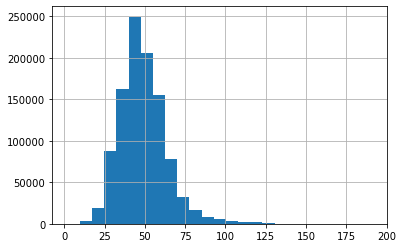

In [3]:
molData['canonicalSmilesLength'].hist(bins=25)

In [4]:
criterion = (molData['positiveCharged'] == 0) & \
            (molData['negativeCharged'] == 0) & \
            (molData['canonicalSmilesLength'] <= 75) & \
            (molData['canonicalSmilesLength'] >= 25) & \
            (molData['organicChemistryElementsOnly'])
sampleData = molData[criterion].sample(n=100000, random_state=randomState)   

In [5]:
maxLen = max(sampleData['canonicalSmiles'].apply(lambda x: len(x)))
minLen = min(sampleData['canonicalSmiles'].apply(lambda x: len(x)))
maxLen, minLen

(75, 25)

<AxesSubplot:>

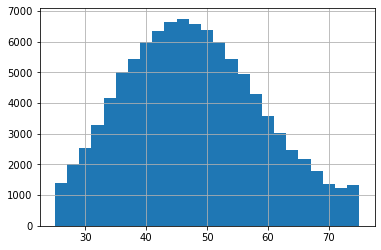

In [6]:
sampleData['canonicalSmilesLength'].hist(bins=25)

<AxesSubplot:>

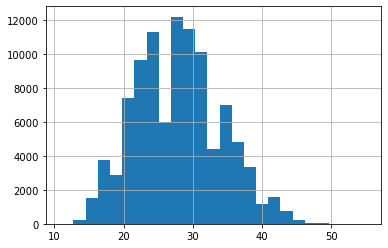

In [7]:
sampleData['numberOfAtoms'].hist(bins=25)

In [8]:
tmp = set()
for ele in sampleData['elementsSet']:
    tmp = tmp | set(ele)
tmp

{'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S'}

### Remove the rows where square brackets are involved in other than N-H groups (just pretty few...)

In [9]:
mask = sampleData['canonicalSmiles'].apply(lambda x: set(x) > set('[') or set(x) > set(']'))
mask2 = sampleData[mask]['canonicalSmiles'].apply(lambda x: x.find('[nH]') < 0)
rowsToBeRemoved = sampleData[mask][mask2].index
for item in sampleData.loc[rowsToBeRemoved, 'canonicalSmiles']:
    print(item)

CCC(NC(CC(C)C)C(=O)NC(Cc1ccc(OC)cc1)C(=O)NC)[PH](=O)O
Nc1nc(O)cc(OCCOC[PH](=O)O)n1
NCC(C[PH](=O)O)c1ccc(F)cc1
NCCCCN(Cc1nccc2c3ccccc3n(CC(=O)[IH2]=O)c12)C1CCCc2cccnc21


In [10]:
sampleData = sampleData.drop(rowsToBeRemoved)

### Replacing multi-character entities

In [11]:
def postprocesSmiles(smiles):
    replacementDict = {'Br': 'G', 'Cl': 'U', '[nH]': 'W'}
    for key in replacementDict.keys():
        smiles = smiles.replace(key, replacementDict[key])
    return smiles

In [12]:
def pad_smile(string, max_len, padding='right'):
    if len(string) <= max_len:
        if padding == 'right':
            return string + " " * (max_len - len(string))
        elif padding == 'left':
            return " " * (max_len - len(string)) + string
        elif padding == 'none':
            return string

In [13]:
sampleData['canonicalSmilesPadded'] = sampleData['canonicalSmiles'].apply(postprocesSmiles).apply(lambda x: pad_smile(x, max_len=maxLen, padding='right'))

### Coding the smiles into vectors

In [14]:
chars = sorted(list(set(sampleData['canonicalSmilesPadded'].str.cat(sep=''))))
print('total chars:', len(chars))
print(chars)
char2indices = dict((c, i) for i, c in enumerate(chars))
indices2char = dict((i, c) for i, c in enumerate(chars))

dynamicFeatures = np.zeros((sampleData.shape[0], maxLen, len(chars)), dtype=np.float)
print(dynamicFeatures.shape)

for codeidx, code in enumerate(sampleData['canonicalSmilesPadded'].tolist()):
    for charidx, char in enumerate(code):
        dynamicFeatures[codeidx, charidx, char2indices[char]] = 1

total chars: 30
[' ', '#', '(', ')', '-', '.', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'C', 'F', 'G', 'I', 'N', 'O', 'P', 'S', 'U', 'W', 'c', 'n', 'o', 's']
(99996, 75, 30)


In [15]:
dynamicFeatures.shape

(99996, 75, 30)

### Architecture preparation

In [39]:
from tensorflow.keras.layers import Bidirectional, LSTM, TimeDistributed, concatenate, Input, Dense, RepeatVector, Lambda,  Convolution1D, Flatten, GRU, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras import losses
from tensorflow.keras.losses import binary_crossentropy
import tensorflow
tensorflow.compat.v1.disable_eager_execution()
#from tensorflow.keras import objectives

from trainHistory import trainHistory
import datetime

import numpy.random as rnd

In [40]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [41]:
def prepareEncoderCNNDynamic(nCharInSmiles, nCharSet, k, lr, variational, showArch):

    convDefinition = k[0]
    input_dynamic = Input(shape=(nCharInSmiles, nCharSet), name="inputDynamic")
    h = Convolution1D(convDefinition['initialDimWidth'], convDefinition['initialDimDepth'], activation = 'relu', name='conv_0')(input_dynamic)

    for iLayer in range(convDefinition['nCNNlayers'] - 1):
        iWidth = int(convDefinition['initialDimDepth'] * convDefinition['expansionCoeff'] ** iLayer)
        iDepth = int(convDefinition['initialDimDepth'] * convDefinition['expansionCoeff'] ** iLayer)
        h = Convolution1D(iWidth, iDepth, activation = 'relu', name='conv_'+str(iLayer+1))(h)
        #h = Dropout(0.1)(h)
        h = BatchNormalization()(h)

    h = Flatten(name='flatten_1')(h)
    output = Dense(k[1], activation = 'relu', name='dense_1')(h)

    # autoencoder
    if (variational):
        #z_mean = Dense(x, name='z_mean')(encoder)
        #z_log_var = Dense(x, name='z_log_var')(encoder)
        z_mean = Dense(k[1], name='z_mean')(output)
        z_log_var = Dense(k[1], name='z_log_var')(output)
        z = Lambda(sampling, output_shape=(k[1],), name='encoderOutput')([z_mean, z_log_var])
        def vae_loss(x, x_decoded_mean):
            x = K.flatten(x)
            x_decoded_mean = K.flatten(x_decoded_mean)
            xent_loss = nCharInSmiles * binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
            return xent_loss + kl_loss
    else:
        z = Dense(k[1], activation="relu", name='encoderOutput')(output)
        vae_loss = None


    model = Model(inputs=[input_dynamic], outputs=[z])
    if (showArch):
        print(model.summary())

    return model, vae_loss

def prepareDecoderCNNDynamic(nCharInSmiles, nCharSet, k, lr, showArch):
    decoderInput = Input(shape=(k[0],), name="decoderInput")

    h = Dense(k[0], name='latent_input', activation = 'relu')(decoderInput)
    h = RepeatVector(nCharInSmiles, name='repeat_vector')(h)
    for idx, iLayer in enumerate(k[1:]):
        h = Bidirectional(LSTM(iLayer, return_sequences = True, name='gru_'+str(idx)))(h)
        #h = GRU(iLayer, return_sequences = True, name='gru_'+str(idx))(h)
        #h = Dropout(0.1)(h)

    resultDynamic = TimeDistributed(Dense(nCharSet, activation='softmax'), name='decoded_mean')(h)

    model = Model(inputs=[decoderInput], outputs=[resultDynamic])
    if (showArch):
        print(model.summary())

    return model

In [42]:
def fitOnlyDynamic(dynamicFeatures, model, modelFilePath, nEpoch, nBatch, iniLR):
    dtime = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    order = rnd.permutation(dynamicFeatures.shape[0])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    checkpoint = ModelCheckpoint(modelFilePath, save_best_only=True, save_weights_only=False, monitor='val_loss')

    size = int(dynamicFeatures.shape[0] * 0.9)
    training_dynamic = dynamicFeatures[order[:size]]
    testing_dynamic = dynamicFeatures[order[size:]]
    print(training_dynamic.shape)
    print(testing_dynamic.shape)

    optimizationEvolution = trainHistory(iniLR, 0.5, 20, dtime)

    history = model.fit(training_dynamic,
              training_dynamic,
                   epochs=nEpoch,
                   batch_size=nBatch,
                   #callbacks=[early_stopping, checkpoint, optimizationEvolution],
                   callbacks=[early_stopping, checkpoint],
                   validation_data=(testing_dynamic,
                                    testing_dynamic))
    return model, history

In [43]:
def trainModelDynamic(dynamicFeatures, encoderDimensions, decoderDimensions, modelFile, nEpoch, nBatch, lr):
    nCharInSmiles = dynamicFeatures.shape[1]
    nCharSet = dynamicFeatures.shape[2]
    decoderChoice = 0
    variational = True
    encoder, vae_loss = prepareEncoderCNNDynamic(nCharInSmiles, nCharSet, encoderDimensions, lr, True, True)
    if decoderChoice == 0:
        decoder = prepareDecoderCNNDynamic(nCharInSmiles, nCharSet, decoderDimensions, lr, True)
    elif decoderChoice == 1:
        decoder = prepareDecoderCNN_LSTMDynamic(nCharInSmiles, nCharSet, decoderDimensions, lr, True)
    encoderOutput = encoder.get_layer('encoderOutput').output
    decoderOutput = decoder(encoderOutput)
    autoencoder = Model(inputs=encoder.input, outputs=decoderOutput)

    #optimizer = RMSprop(lr=lr)
    optimizer = Adam(lr)
    if variational:
        lossF = vae_loss
    else:
        loddF = 'categorical_crossentropy'

    autoencoder.compile(optimizer=optimizer, loss=lossF, metrics=['categorical_crossentropy', 'mean_absolute_error', 'accuracy'])

    print(autoencoder.summary())
    #model = prepareModelDynamicStatic(dynamicFeatures.shape, staticFeatures.shape, [64,64,64,32], lr, ['binary_crossentropy', 'mean_absolute_error'], True)
    model, history = fitOnlyDynamic(dynamicFeatures, autoencoder, modelFile, nEpoch, nBatch, lr)
    return model, history

In [46]:
lr = 0.00038
latentDim = 256
convDefinition = {}
convDefinition['initialDimWidth'] = 7
convDefinition['initialDimDepth'] = 7
convDefinition['nCNNlayers'] = 6
convDefinition['expansionCoeff'] = 1.2
encoderDimensions = [convDefinition, latentDim]
decoderDimensions = [latentDim, 512, 128, 128]

hyperParameters = {}
hyperParameters['latentDim'] = latentDim
hyperParameters['convDefinition'] = convDefinition
hyperParameters['encoderDimensions'] = encoderDimensions
hyperParameters['decoderDimensions'] = decoderDimensions
hyperParameters['lr'] = lr

modelWeightsFile = 'model_20200413.h5'
nEpoch = 50
nBatch = 196

In [ ]:
model, history = trainModelDynamic(dynamicFeatures, encoderDimensions, decoderDimensions, modelWeightsFile, nEpoch, nBatch, lr)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputDynamic (InputLayer)       [(None, 75, 30)]     0                                            
__________________________________________________________________________________________________
conv_0 (Conv1D)                 (None, 69, 7)        1477        inputDynamic[0][0]               
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 63, 7)        350         conv_0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 63, 7)        28          conv_1[0][0]                     
___________________________________________________________________________________________

(89996, 75, 30)
(10000, 75, 30)
Train on 89996 samples, validate on 10000 samples
Epoch 1/50
89996/89996 [==============================] - 119s 1ms/sample - loss: 5.4108 - categorical_crossentropy: 1.5051 - mean_absolute_error: 0.0375 - accuracy: 0.5384 - val_loss: 5.0965 - val_categorical_crossentropy: 1.4231 - val_mean_absolute_error: 0.0359 - val_accuracy: 0.5529
Epoch 2/50
89996/89996 [==============================] - 110s 1ms/sample - loss: 5.0817 - categorical_crossentropy: 1.4172 - mean_absolute_error: 0.0358 - accuracy: 0.5530 - val_loss: 5.0192 - val_categorical_crossentropy: 1.3984 - val_mean_absolute_error: 0.0357 - val_accuracy: 0.5571
Epoch 3/50
89996/89996 [==============================] - 110s 1ms/sample - loss: 5.0228 - categorical_crossentropy: 1.4000 - mean_absolute_error: 0.0355 - accuracy: 0.5559 - val_loss: 4.9653 - val_categorical_crossentropy: 1.3847 - val_mean_absolute_error: 0.0352 - val_accuracy: 0.5597
Epoch 4/50
89996/89996 [==============================

## The end

In [ ]:
from SmilesEnumerator import SmilesEnumerator

In [ ]:
sme = SmilesEnumerator()
sme.rand

In [ ]:
smiles = molData.loc[:24,'canonicalSmiles']

In [ ]:
#smiles = np.array([ "CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2",
#                    "CCC[S@@](=O)c1ccc2c(c1)[nH]/c(=N/C(=O)OC)/[nH]2"]*10
#                        )
#Test canonical SMILES vectorization
sm_en = SmilesEnumerator(canonical=True, enum=False)
sm_en.fit(smiles, extra_chars=["\\"])
v = sm_en.transform(smiles)
transformed = sm_en.reverse_transform(v)
if len(set(transformed)) > 2: print("Too many different canonical SMILES generated")

In [ ]:
transformed

In [ ]:
v.shape

In [ ]:
smiles = molData[('canonical_smiles', 'min')]

In [ ]:
charges = []
canSmiles = []
for idx, smile in enumerate(smiles):
    try:
        mol = Chem.MolFromSmiles(smile)
        charge = Chem.GetFormalCharge(mol)
        canonicalSmiles = Chem.MolToSmiles(mol, isomericSmiles = True, canonical = True)
    except:
        charge = None
        canonicalSmiles = None
    finally:
        charges.append(charge)
        canSmiles.append(canonicalSmiles)
    if (idx % 50000 == 0):
        print(idx)

In [ ]:
canonicalSmilesMap = {}
duplicates = []
for smiles in canSmiles:
    if smiles in canonicalSmilesMap:
        duplicates.append(smiles)
    else:
        canonicalSmilesMap[smiles] = smiles

In [ ]:
len(duplicates)

In [ ]:
molData = pd.concat([molData, pd.DataFrame(charges, columns=['charge'])], axis=1)

In [ ]:
molData = molData[molData['charge'] == 0]

In [ ]:
pd.DataFrame(charges).hist(bins=10)

In [ ]:
mol = Chem.MolFromSmiles(molData[('canonical_smiles', 'min')][0])


Chem.GetSSSR(mol)
print(Chem.GetFormalCharge(mol))

In [ ]:
os.chdir('/home/rafalb/work/molecules/chemicalSmilesSpace/src')
picklesDir = 'pickles/'
DBread = False
if DBread:
    connection = connect2DB()
    molData = getSmilesWithActivity(connection)
    connection.close()
    molData.to_pickle(picklesDir+'molDataRaw.pkl')